- 本项目数据集该提供了15万条用户样本，每条样本包含12列属性，分别从还款率、额度使用率、历史逾期特征、借款人信息等不同维度出发对用户进行刻画。项目任务是根据用户的行为特征等预测用户在未来出现“90天或更长时间的逾期行为”的概率。
    - SeriousDlqin2yrs为标签数据，其他为特征数据

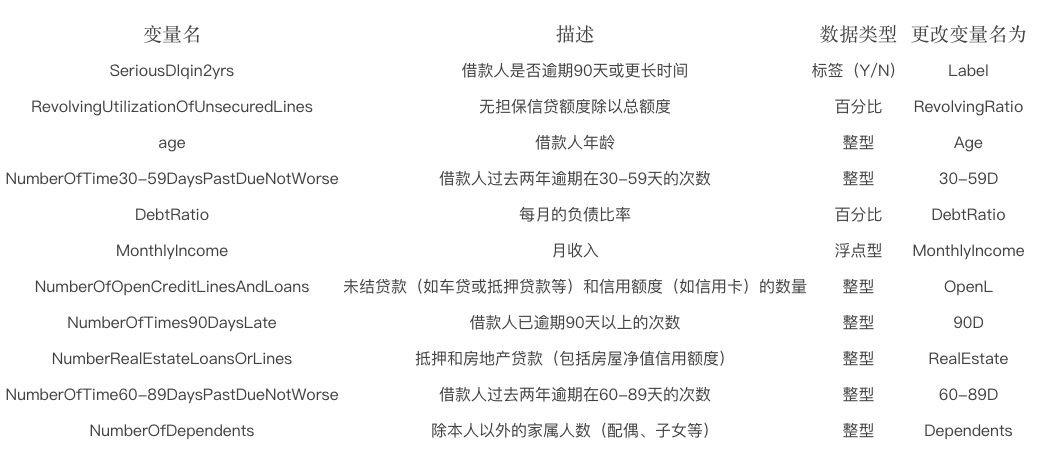

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') #  忽略弹出的warnings

data = pd.read_csv('rankingcard.csv')
data.drop(labels='Unnamed: 0',axis=1,inplace=True)
# data.head(10)

In [4]:
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [2]:
data.shape

(150000, 11)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

- 由于变量名大多过长，因此需要进行一定的简化

In [5]:
### 整理数据集
data.columns = ['Label', 'RevolvingRatio', 'Age', '30-59D', 'DebtRatio', 'MonthlyIncome',
                'OpenL', '90D', 'RealEstate', '60-89D', 'Dependents']    # 列重命名
data.head()    # 观察整理后数据集 

,Label,RevolvingRatio,Age,30-59D,DebtRatio,MonthlyIncome,OpenL,90D,RealEstate,60-89D,Dependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [155]:
data.shape

(150000, 11)

### 数据预处理

#### 缺失值处理

In [6]:
missingDf = data.isnull().sum().sort_values(ascending=False).reset_index()
missingDf.columns = ['feature', 'miss_num']    
missingDf['miss_percentage'] = missingDf['miss_num'] / data.shape[0]    # 缺失值比例
missingDf

,feature,miss_num,miss_percentage
0,MonthlyIncome,29731,0.198207
1,Dependents,3924,0.026160
2,60-89D,0,0.000000
3,RealEstate,0,0.000000
4,90D,0,0.000000
5,OpenL,0,0.000000
6,DebtRatio,0,0.000000
7,30-59D,0,0.000000
8,Age,0,0.000000
9,RevolvingRatio,0,0.000000


- 可以发现所有特征中仅有两列含缺失值，即MonthlyIncome（月收入）和Dependents（家属人数）。
    - 其中月收入特征缺失比例为19.8%，缺失较多，不能直接删除对应样本，本案例中选用随机森林进行建模填充；
    - 家属人数特征缺失比例为2.6%，占比较小，可以考虑删除对应样本行，也可以进行填充，为了尽可能多地利用数据，本案例选用众数进行填充。

- MonthlyIncome特征处理

In [7]:
from sklearn.ensemble import RandomForestRegressor    
# 用MonthlyIncome特征值非空的样本构建训练集，MonthlyIncome特征值缺失的样本构建测试集
#月收入为预测结果
df = data.iloc[:, [5,1,2,3,4,6,7,8,9]]# 原始数据集中的无缺失数值特征（不包含Dependents列）
train = df.loc[df['MonthlyIncome'].notnull()] #月收入值为非空
test = df.loc[df['MonthlyIncome'].isnull()] #月收入值为空
   
# 划分训练数据的特征和标签（label）
x_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
# 测试数据的特征数据
x_test = test.iloc[:,1:] 
# 训练过程
rf = RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,n_jobs=-1) 
rf.fit(x_train, y_train)
# 预测过程
pred = rf.predict(x_test).round(0)    # 预测值四舍五入并保留一位小数点

In [8]:
#填补缺失值
data.loc[(data['MonthlyIncome'].isnull()),'MonthlyIncome'] = pred    

- Dependents特征处理

In [9]:
# 这里采用众数(出现次数最多的数值)填充
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)    

#### 异常值处理
- 用箱型图可以直观地对每一列特征进行观察，找到偏离正常范围较大的异常值。


- 探测百分比类特征中是否存在异常值
    - 百分比类特征有：
        - RevolvingRatio：无担保信贷额度除以总额度
        - DebtRatio：每月的负债比率

Text(0.5, 1.0, 'RevolvingRatio')

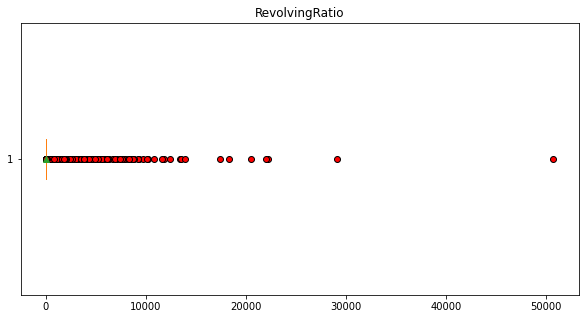

In [10]:
#vert横向，showmeans显示均值，flierprops设置异常值属性
plt.figure(figsize=(10,5))
a = plt.boxplot(data['RevolvingRatio'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"red"})
plt.title('RevolvingRatio')

Text(0.5, 1.0, 'DebtRatio')

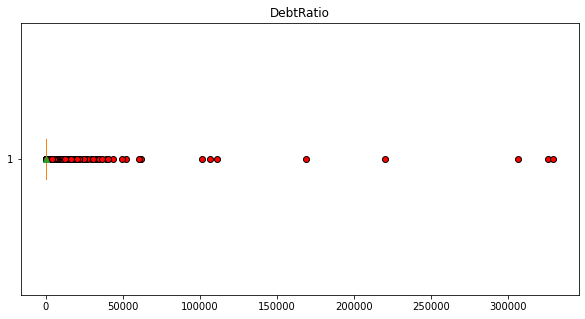

In [11]:
plt.figure(figsize=(10,5))
aa = plt.boxplot(data['DebtRatio'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"red"})
plt.title('DebtRatio')

- 从实际意义出发进行理解这两者的取值范围都应该在[0,1]之间。因此选择的处理方法是将大于1的特征值视为异常值，用[0,1]之间特征值的均值进行填充

In [12]:
r_s = data[data['RevolvingRatio'] <= 1]    # 去掉高于1的部分
mean_value = r_s['RevolvingRatio'].mean()
#填充
data.loc[data['RevolvingRatio']>1,'RevolvingRatio'] = mean_value

In [13]:
r_s = data[data['DebtRatio'] <= 1]    # 去掉高于1的部分
mean_value = r_s['DebtRatio'].mean()
#填充
data.loc[data['DebtRatio']>1,'DebtRatio'] = mean_value

- 探测逾期类特征中是否存在异常值
    - 逾期特征：30-59D，60-89D，90D

Text(0.5, 1.0, '30-59D')

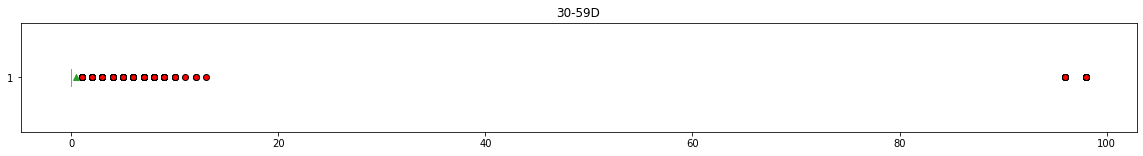

In [14]:
plt.figure(figsize=(20,2))
a1 = plt.boxplot(data['30-59D'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"red"})
plt.title('30-59D')

Text(0.5, 1.0, '60-89D')

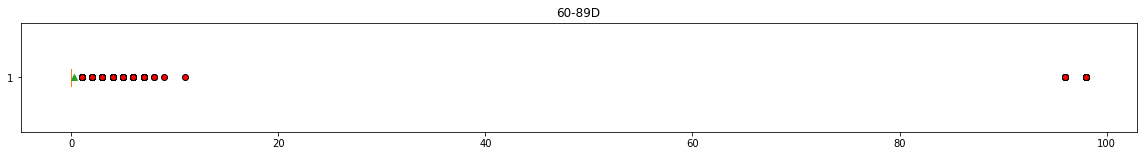

In [15]:
plt.figure(figsize=(20,2))
a1 = plt.boxplot(data['60-89D'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"red"})
plt.title('60-89D')

Text(0.5, 1.0, '90D')

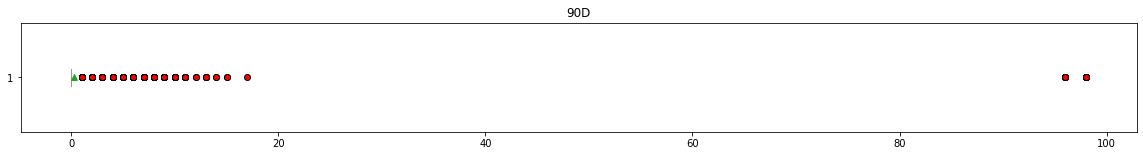

In [16]:
plt.figure(figsize=(20,2))
a1 = plt.boxplot(data['90D'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"red"})
plt.title('90D')

In [17]:
#根据图例我们可以将大于20的数值作为异常值，下面统计三列特征存在异常值的数量
row1 = data[data['30-59D'] > 80]
print("30-59D特征的异常样本数：", row1.shape[0])
row2 = data[data['60-89D'] > 80]
print("60-89D特征的异常样本数：", row2.shape[0])
row3 = data[data['90D'] > 80]
print("90D特征的异常样本数：", row3.shape[0])

30-59D特征的异常样本数： 269
60-89D特征的异常样本数： 269
90D特征的异常样本数： 269


In [18]:
#异常值数量不多，可以直接将其删除
data.drop(data[data['30-59D']  > 80].index, inplace = True)   
data.drop(data[data['60-89D']  > 80].index, inplace = True)    
data.drop(data[data['90D']  > 80].index, inplace = True)    

In [19]:
data.shape

(149731, 11)

- 探测年龄特征中是否存在异常值

Text(0.5, 1.0, 'Age')

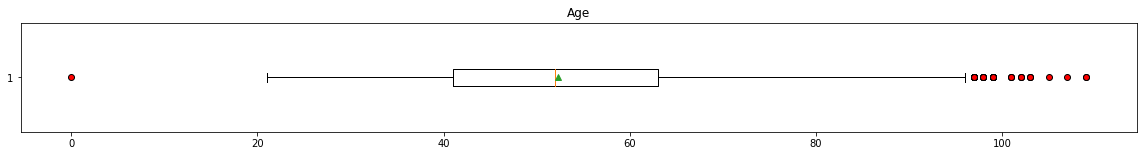

In [20]:
plt.figure(figsize=(20,2))
a1 = plt.boxplot(data['Age'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"red"})
plt.title('Age')

- Age代表借款人的年龄，从箱型图中很明显可以看出，年龄取值为0是异常值，由于只有一条样本，因此可以直接删除；而从实际情况出发，我们认为年龄在100左右的人应当不在借贷用户的年龄范围内，因此同样将超过箱型图上须的样本删除。

In [21]:
data.drop(labels=data.loc[data['Age'] == 0].index,inplace=True)
data.drop(labels=data.loc[data['Age'] >= 100].index,inplace=True)

In [22]:
data.shape

(149717, 11)

- 探测其余特征中是否存在异常值
    - MonthlyIncome特征：月收入
    - OpenL特征：未结贷款和信用额度的数量
    - RealEstate特征：抵押和房地产贷款数量
    - Dependents特征：除本人以外的家属人数

Text(0.5, 1.0, 'MonthlyIncome')

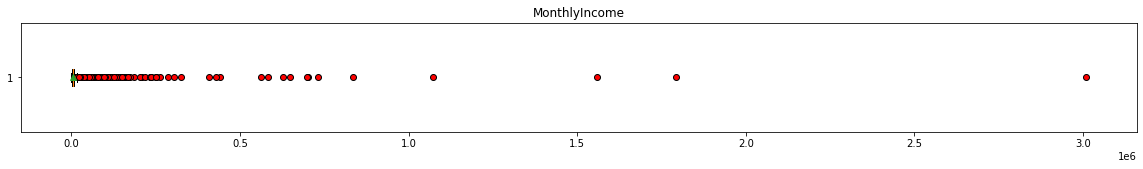

In [23]:
#月收入
plt.figure(figsize=(20,2))
a1 = plt.boxplot(data['MonthlyIncome'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"red"})
plt.title('MonthlyIncome')

Text(0.5, 1.0, 'OpenL')

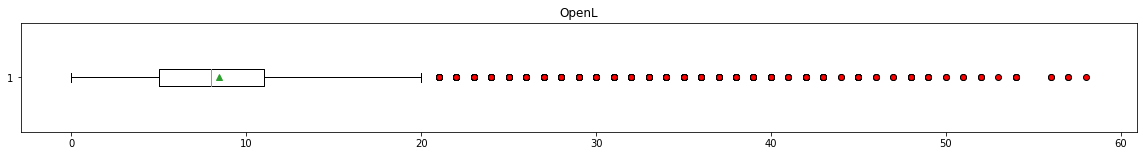

In [24]:
#未结贷款和信用额度的数量
plt.figure(figsize=(20,2))
a1 = plt.boxplot(data['OpenL'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"red"})
plt.title('OpenL')

Text(0.5, 1.0, 'RealEstate')

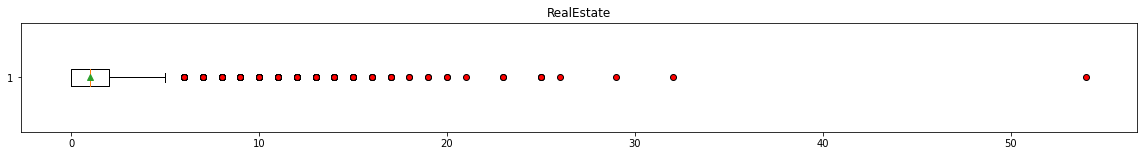

In [25]:
#抵押和房地产贷款数量
plt.figure(figsize=(20,2))
a1 = plt.boxplot(data['RealEstate'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"red"})
plt.title('RealEstate')

Text(0.5, 1.0, 'Dependents')

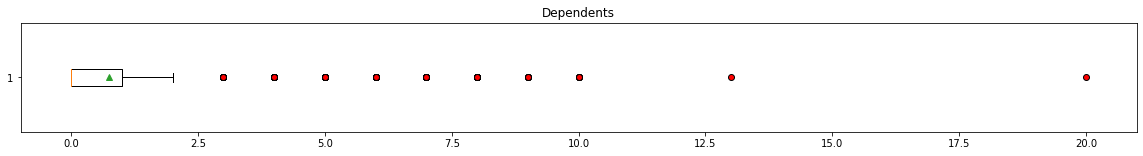

In [26]:
#除本人以外的家属人数
plt.figure(figsize=(20,2))
a1 = plt.boxplot(data['Dependents'],vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"red"})
plt.title('Dependents')

- 从上图中，可看到上述4列特征均可能存在一定量的异常值，且异常值均分布在箱型图的其中一侧。我们在此暂时不进行处理，因为后续还有特征分箱环节。分箱可以直接将这些异常值限制在最右侧箱体中并进行重新编码（如果箱体中的IV值极低则可以考虑删除异常值），而不会用到原始特征值，这样也可以起到处理异常值的作用。

### 特征工程

#### 特征相关性分析

<AxesSubplot:>

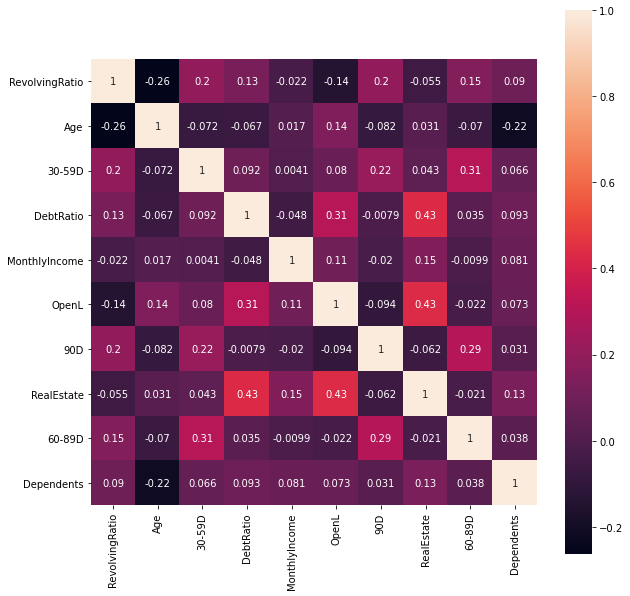

In [24]:
plt.figure(figsize=(10,10))
feature_names = data.columns[1:]
fea_corr = data[feature_names].corr()
seaborn.heatmap(data=fea_corr,square=True,annot=True)

- 由图可观察到各个特征之间的相关性较小，可以初步判定特征之间不存在明显的多重共线性问题（相关系数绝对值小于0.6），暂时不需要删除冗余特征。

#### 新特征构建

- 原始数据集中有10列特征，我们可以再构建一些新的连续值特征作为备选，同时也可对比原特征与新特征的预测能力。
    - IncAvg:家庭中每个人分摊的平均月收入
        - 月收入 / 家属人数+1
    - MonthlyDept:每月的债务
        - 月收入*每月的负债比率
    - DeptAvg:家庭中平均每个人分摊每月应还债务
        - 每月债务 / 家属人数+1

In [27]:
### 构建新特征
# IncAvg:家庭中每个人分摊的平均月收入
data['IncAvg'] = data['MonthlyIncome'] / (data['Dependents'] + 1)    
# MonthlyDept:每月的债务
data['MonthlyDept'] = data['MonthlyIncome'] * data['DebtRatio']
# DeptAvg:家庭中平均每个人分摊每月应还债务
data['DeptAvg'] = data['MonthlyDept'] / (data['Dependents'] + 1)

data[['IncAvg', 'MonthlyDept', 'DeptAvg']].head(10)    # 查看新特征

,IncAvg,MonthlyDept,DeptAvg
0,3040.000000,7323.197016,2441.065672
1,1300.000000,316.878123,158.439061
2,3042.000000,258.914887,258.914887
3,3300.000000,118.963951,118.963951
4,63588.000000,1584.975094,1584.975094
5,1750.000000,1314.624392,657.312196
6,8311.000000,2518.413491,2518.413491
7,3500.000000,734.790059,734.790059
8,1159.000000,351.202170,351.202170
9,7894.666667,14359.393699,4786.464566


#### 分箱
- 最优分箱：也称自动化分箱，通常采用一个评价指标来判断分箱合适的宽度和频率，评判标准可以是卡方值（卡方分箱）、熵值（单变量决策树算法）、相关系数（下属操作采用该种形式）、IV值等等。
- 自定义分箱：如果常用的分箱方法不能满足要求的话，还可以从业务解释或者数据分布出发，自行划分箱体区间，做自定义分箱。

- 最优分箱/自动分箱函数定义

In [28]:
### 定义分箱函数：最优分箱/自动分箱函数定义
from scipy.stats import stats
def optimal_bins(Y, X, n):
    """
    :param Y: 目标变量（0，1组成的二分类结果）
    :param X: 待分箱特征
    :param n: 分箱数初始值
    :return: 统计值、分箱边界值列表、woe值、iv值
    """
    r = 0 #相关系数的初始值
    total_bad = Y.sum() # 总的坏样本数
    total_good = Y.count() - total_bad # 总的好样本数
    # 分箱过程
    while np.abs(r) < 1:  #相关系数的绝对值等于1结束循环，循环追求最好正反高相关性  
        #df1中的bin为给X分箱对应的结果
        df1 = pd.DataFrame({'X':X, 'Y':Y, 'bin':pd.qcut(X, n,duplicates='drop')})#drop表示删除重复元素
        #将df1基于箱子进行分组
        df2 = df1.groupby('bin')
        #r返回的是df1对箱子分组后，每组数据X的均值和Y的均值的相关系数，如果系数不为正负1，则减少分箱的箱数
        #corr也可以计算相关系数
        r,p = stats.spearmanr(df2.mean().X,df2.mean().Y)
        #分箱后要追求X，Y的最高相关性。相关性越高则表示特征X对于分类结果越重要
        n = n - 1
    # 计算woe值和iv值
    df3 = pd.DataFrame()
    df3['sum'] = df2.sum().Y#基于箱子分组后，每组中1类别（坏样本）样本数量
    df3['total'] = df2.count().Y#基于箱子分组后，每组中所有样本的数量
    df3['badattr'] = df3['sum'] / total_bad#每组中坏样本占数据集中所有坏样本的比例
    df3['goodattr'] = (df3['total'] - df3['sum']) / total_good#每组中好样本占数据集中所有好样本的比例
    df3['woe'] = np.log(df3['badattr'] / df3['goodattr'])
    iv = ((df3['badattr'] - df3['goodattr']) * df3['woe']).sum()
    # 分箱边界值列表
    cut = []
    for i in range(1, n+2):#i的取值范围是1-》(n+1)，n+1是分箱的数量
        #quantile把给定的乱序数值由小到大排列并分成n等份，参数表示取出第百分之多少大小的数值
        #i的取值范围是1-n，则quantile参数以此为1/n,2/n,n/n,则表示以此取出每个箱子最右侧值(箱子范围的最大值)
        qua = X.quantile(i / (n+1))
        cut.append(round(qua, 6))
    # woe值列表
    woe = list(df3['woe'])
    return df3, cut, woe, iv

- 观察RevolvingRatio特征各分箱情况

In [51]:
rrDf, cut_rr, woe_rr, iv_rr = optimal_bins(data.Label,data.RevolvingRatio,n=10)
rrDf

,sum,total,badattr,goodattr,woe
bin,,,,,
"(-0.001, 0.0298]",687,37430,0.069548,0.262752,-1.329187
"(0.0298, 0.153]",744,37429,0.075319,0.262337,-1.247900
"(0.153, 0.504]",2819,37429,0.285382,0.247499,0.142421
"(0.504, 1.0]",5628,37429,0.569751,0.227412,0.918438


In [52]:
#观察RevolvingRatio特征分箱边界：则分了四个箱子
cut_rr

[0.029776, 0.153496, 0.504152, 1.0]

- 对MonthlyIncome、Age、DebtRatio特征进行分箱处理

In [53]:
# MonthlyIncome特征
miDf,cut_mi,woe_mi,iv_mi = optimal_bins(data.Label,data.MonthlyIncome,n=10)
print("MonthlyIncome特征分箱情况：", cut_mi)
# Age特征
ageDf,cut_age,woe_age,iv_age = optimal_bins(data.Label,data.Age,n=10)
print("Age特征分箱情况：", cut_age)
# DebtRatio特征
drDf,cut_dr,woe_dr,iv_dr = optimal_bins(data.Label,data.DebtRatio,10)
print("DebtRatio特征分箱情况：", cut_dr)

MonthlyIncome特征分箱情况： [3299.0, 6750.0, 3008750.0]
Age特征分箱情况： [33.0, 40.0, 45.0, 50.0, 54.0, 59.0, 64.0, 71.0, 99.0]
DebtRatio特征分箱情况： [0.238913, 0.31217, 1.0]


- 对新特征进行分箱处理

In [54]:
### 新特征
# IncAvg特征
newDf1,cut_new1,woe_new1,iv_new1 = optimal_bins(data.Label, data.IncAvg, 10)
# MonthlyDept特征
newDf2,cut_new2,woe_new2,iv_new2 = optimal_bins(data.Label, data.MonthlyDept, 10)
# DeptAvg特征
newDf3,cut_new3,woe_new3,iv_new3 = optimal_bins(data.Label, data.DeptAvg, 10)

print("IncAvg特征特征分箱情况：", cut_new1)
print("MonthlyDept特征分箱情况：", cut_new2)
print("DeptAvg特征分箱情况：", cut_new3)

IncAvg特征特征分箱情况： [1700.0, 2959.0, 5400.0, 1794060.0]
MonthlyDept特征分箱情况： [57086.823924]
DeptAvg特征分箱情况： [351.20217, 773.917466, 1591.666665, 57086.823924]


- 观察到MonthlyDept特征进行分箱，分箱边界为[x]表示【箱子数为1则表示特征列和标签不相关，不建议分箱】
    - MonthlyDept不适合使用最优分箱方法，需要寻找新的分箱方法进行处理。

- 对其他6列原始特征，用最优分箱计算效果同样较差

In [55]:
df1,cut1,woe1,iv1 = optimal_bins(data.Label,data['30-59D'],n=10)
print(cut1)
df2,cut2,woe2,iv2 = optimal_bins(data.Label,data.OpenL,n=10)
print(cut2)
df3,cut3,woe3,iv3 = optimal_bins(data.Label,data['90D'],n=10)
print(cut3)
df4,cut4,woe4,iv4 = optimal_bins(data.Label,data['60-89D'],n=10)
print(cut4)
df5,cut5,woe5,iv5 = optimal_bins(data.Label,data.RealEstate,n=10)
print(cut5)
df6,cut6,woe6,iv6 = optimal_bins(data.Label,data.Dependents,n=10)
print(cut6)

[0.0, 0.0, 0.0, 0.0, 0.0, 13.0]
[58.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0]
[54.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 20.0]


- 原因可能是某些特征值占比过高、阈值设置不合适等等，因此不能满足最优分段的要求。又由于特征不多且容易观察，因此本案例采取自定义分箱的方式进行处理。

- 自定义分箱函数定义

In [63]:
### 定义分箱函数
def custom_bins(Y, X, binList):
    """
    :param Y: 目标变量
    :param X: 待分箱特征
    :param binList: 分箱边界值列表
    :return: 统计值、woe值、iv值
    """
    r = 0
    total_bad = Y.sum()     
    total_good = Y.count() - total_bad
    # 等距分箱
    df1 = pd.DataFrame({'X':X, 'Y':Y, 'bin':pd.cut(X, binList)})
    df2 = df1.groupby('bin', as_index = True)
    r, p = stats.spearmanr(df2.mean().X, df2.mean().Y)
    # 计算woe值和iv值 
    df3 = pd.DataFrame()
    df3['min_'+X.name] = df2.min().X 
    df3['max_'+X.name] = df2.max().X 
    df3['sum'] = df2.sum().Y
    df3['total'] = df2.count().Y
    df3['rate'] = df2.mean().Y
    df3['badattr'] = df3['sum'] / total_bad
    df3['goodattr'] = (df3['total'] - df3['sum']) / total_good
    df3['woe'] = np.log(df3['badattr'] / df3['goodattr'])
    iv = ((df3['badattr'] - df3['goodattr']) * df3['woe']).sum()
    df3 = df3.sort_values(by='min_'+X.name).reset_index(drop=True)
    woe = list(df3['woe'])
    
    return df3, woe, iv

- 对MonthlyDept进行自定义分箱
    - 定义分箱边界
        - 通常是根据特征列的describe()中的25%，50%，75%作为边界

In [64]:
data['MonthlyDept'].describe()[['25%','50%','75%']]

25%     412.922088
50%    1207.766794
75%    2518.413491
Name: MonthlyDept, dtype: float64

In [68]:
# 新特征MonthlyDept自定义分箱
ninf = float('-inf')#因为特征元素中存有异常值（使用-inf和inf包含异常值）
pinf = float('inf')
cut_new2 = [ninf, 414, 1209, 2518, pinf]  
#分箱
newDf2, woe_new2, iv_new2 = custom_bins(data.Label, data.MonthlyDept, cut_new2)
newDf2

,min_MonthlyDept,max_MonthlyDept,sum,total,rate,badattr,goodattr,woe
0,0.000000,413.979453,2430,37478,0.064838,0.246001,0.250631,-0.018646
1,414.585415,1208.881762,2584,37420,0.069054,0.261591,0.249115,0.048869
2,1209.136331,2517.832140,2215,34647,0.063930,0.224236,0.231924,-0.033711
3,2518.180547,57086.823924,2649,40172,0.065941,0.268172,0.268330,-0.000590


- 同理对其他剩余特征进行自定义分箱

In [69]:
cut_thirty = [ninf, 0, 1, 3, 5, pinf]    # 30-59D特征
cut_open = [ninf,1, 2, 3, 5, pinf]    # OpenL特征
cut_ninety = [ninf, 0, 1, 3, 5, pinf]    # 90D特征
cut_re = [ninf, 0, 1, 2, 3, pinf]    # RealEstate特征
cut_sixty = [ninf, 0, 1, 3, pinf]    # 60-89D特征
cut_dpt = [ninf, 0, 1, 2, 3, 5, pinf]    # Dependents特征

In [70]:
### 计算统计值、woe和iv
thirtyDf, woe_thirty, iv_thirty = custom_bins(data.Label, data['30-59D'], cut_thirty)    # 30-59D特征
openDf, woe_open, iv_open = custom_bins(data.Label, data.OpenL, cut_open)    # OpenL特征
ninetyDf, woe_ninety, iv_ninety = custom_bins(data.Label, data['90D'], cut_ninety)    # 90D特征
reDf, woe_re, iv_re = custom_bins(data.Label, data.RealEstate, cut_re)    # RealEstate特征
sixtyDf, woe_sixty, iv_sixty = custom_bins(data.Label, data['60-89D'], cut_sixty)    # 60-89D特征
dptDf, woe_dpt, iv_dpt = custom_bins(data.Label, data.Dependents, cut_dpt)    # Dependents特征

- 基于IV值进行特征筛选

In [71]:
### 列表查看iv值
ivDf = pd.DataFrame(columns=['feature', 'iv'])
feaList = list(data.columns[1:])#获取特征列名称
ivList = [iv_rr, iv_age, iv_thirty, iv_dr, iv_mi, iv_open, iv_ninety, iv_re, iv_sixty, iv_dpt, iv_new1, iv_new2, iv_new3]
for i, x in enumerate(feaList):
    ivDf.loc[i, 'feature'] = x
    ivDf.loc[i, 'iv'] = ivList[i]
ivDf = ivDf.sort_values(by='iv', ascending=False).reset_index(drop=True)    # 降序排列
ivDf    # 查看表格

,feature,iv
0,90D,0.847432
1,RevolvingRatio,0.809997
2,30-59D,0.723754
3,60-89D,0.566456
4,Age,0.250771
5,IncAvg,0.0752842
6,OpenL,0.0701032
7,RealEstate,0.0561616
8,MonthlyIncome,0.0422646
9,Dependents,0.037277


- 根据iv值表格，小于0.1的特征可视为弱特征。将iv值小于0.1的特征弃之不用。即删除OpenL、RealEstate、MonthlyIncome、Dependents、DebtRatio 5列原始特征及三列新特征，剩余5列特征进行WOE编码。

In [151]:
### WOE编码
data['90D'] = pd.cut(data['90D'] #分箱
                     , bins=cut_ninety #根据之前定制好的分箱边界进行分箱
                     , labels=woe_ninety) #根据之前计算好的woe的值进行原始数据的替换   

data['RevolvingRatio'] = pd.cut(data['RevolvingRatio'], bins=cut_rr, labels=woe_rr) # RevolvingRatio特征
data['30-59D'] = pd.cut(data['30-59D'], bins=cut_thirty, labels=woe_thirty)    # 30-59D特征
data['60-89D'] = pd.cut(data['60-89D'], bins=cut_sixty, labels=woe_sixty)    # 60-89D特征
data['Age'] = pd.cut(data['Age'], bins=cut_age, labels=woe_age)    # Age特征

# 特征选择
data = data[['Label', '90D', 'RevolvingRatio', '30-59D', '60-89D', 'Age']]    
data.head(10)    # 此时的数据集

,Label,90D,RevolvingRatio,30-59D,60-89D,Age
0,1,-0.375874,0.142421,1.750366,-0.274342,0.268352
1,0,-0.375874,0.142421,-0.527715,-0.274342,0.378037
2,0,1.971875,0.142421,0.917634,-0.274342,0.378037
3,0,-0.375874,-1.247900,-0.527715,-0.274342,0.559990
4,0,-0.375874,0.142421,0.917634,-0.274342,0.204913
5,0,-0.375874,-1.247900,-0.527715,-0.274342,-0.905573
6,0,-0.375874,-1.247900,-0.527715,-0.274342,0.102200
7,0,-0.375874,0.142421,-0.527715,-0.274342,0.378037
8,0,-0.375874,-1.247900,-0.527715,-0.274342,0.559990
9,0,-0.375874,-1.247900,-0.527715,-0.274342,0.102200


### 算法模型构建

- 划分数据集

In [152]:
from sklearn.model_selection import train_test_split    # 数据集划分模块
X = data.iloc[:, 1:]    # 特征
y = data.iloc[:, 0]    # 目标变量
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

- 逻辑回归

In [164]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression()    # 首先全部采用默认值进行训练
clf1 = model1.fit(X_train, y_train)    # 模型训练
y_pred1 = clf1.predict(X_test)    # 模型预测
y_score1 = model1.predict_log_proba(X_test)[:,1]

- 模型评估
    - 二分类问题可以使用ROC曲线和AUC值进行评估

In [178]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_score1)

0.8372427251391301

- 模型调参，自行实现